In [41]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tqdm import tqdm
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Image Processing

In [2]:
# Input Folders
main_folder = 'dataset/traffic_object_detection'
train_folder = f'{main_folder}/train'
test_folder = f'{main_folder}/test'
valid_folder = f'{main_folder}/valid'

classes = ['bicycle', 'bus', 'car', 'motorbike', 'person']
colors = [[0, 255, 0], [255, 0, 0], [0, 255, 0], [200, 200, 0], [200, 200, 200]]

In [3]:
def upscale_points(image, coordinates):
    x = int(coordinates[1] * image.shape[0])
    y = int(coordinates[2] * image.shape[1])
    width = int(coordinates[3] * image.shape[0])
    height = int(coordinates[4] * image.shape[1])
    return (int(coordinates[0]), y, x, height, width)

def draw_boundary(image, color, coordinates):
    (object_class, x, y, width, height) = upscale_points(image, coordinates)
    image[x-width:x+width, y-height:y-height+5, :] = color
    image[x+width:x+width+5, y-height:y+height, :] = color
    image[x-width:x+width, y+height-5:y+height, :] = color
    image[x-width-5:x-width, y-height:y+height, :] = color
    return image, (int(coordinates[0]), x, y, width, height)

def clip(value, prev_min, prev_max, new_min, new_max):
    return int((((value - prev_min) * (new_max - new_min)) / (prev_max - prev_min)) + new_min)

def load_image(folder, images_list, labels_list, index):
    image = plt.imread(f'{folder}/images/{images_list[index]}')
    image = cv2.resize(image, (640, 640))
    object_coordinates = []
    with open(f'{folder}/labels/{labels_list[index]}', 'r') as file:
        label = file.readlines()
    for lab in label:
        coordinates = [float(num) for num in lab.split(' ')]
        coords = upscale_points(image, coordinates)
        object_coordinates.append(coords)
    return image, object_coordinates

## Data Display

aguanambi-1085_png_jpg.rf.ba8bcc4fd6c7cae9f610e611e300bdf1.txt aguanambi-1085_png_jpg.rf.ba8bcc4fd6c7cae9f610e611e300bdf1.jpg


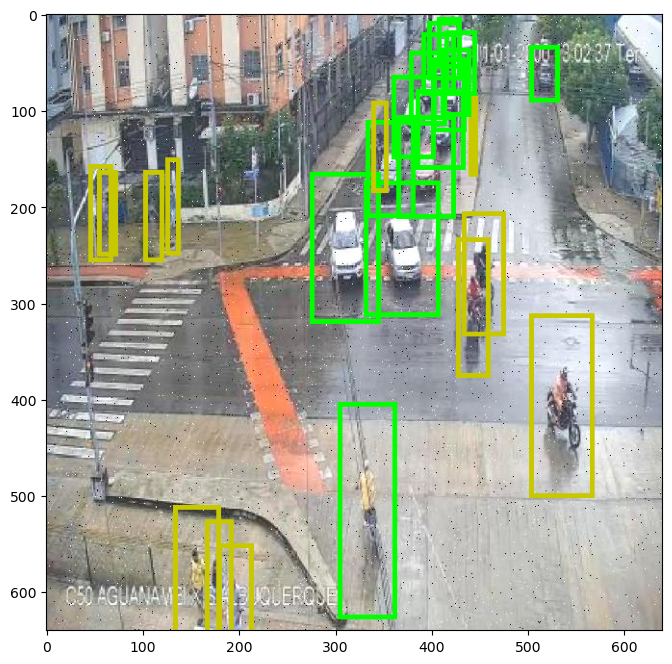

In [118]:
# Loading data
image_index = 5
images = os.listdir(f'{train_folder}/images')
labels = os.listdir(f'{train_folder}/labels')
image = plt.imread(f'{train_folder}/images/{images[image_index]}')
label = ''
object_coordinates = []
with open(f'{train_folder}/labels/{labels[image_index]}', 'r') as file:
    label = file.readlines()
new_image = image.copy()
for lab in label:
    coordinates = [float(num) for num in lab.split(' ')]
    new_image, coords = draw_boundary(new_image, colors[int(coordinates[0])], coordinates)
    object_coordinates.append(coords)

print(labels[image_index], images[image_index])

plt.figure(figsize=(8, 8))
plt.imshow(new_image)

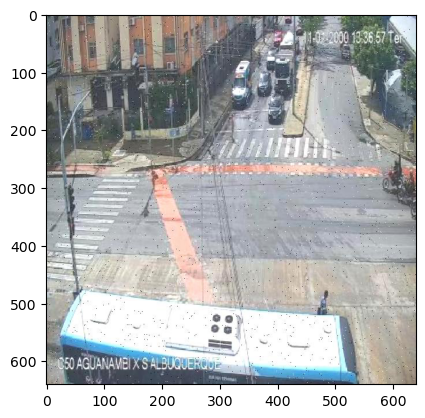

In [120]:
t_image, t_coords = load_image(images, labels, 500)
plt.imshow(t_image)

# Defining Data Generator

In [121]:
# Generates anchor points accross the image
def generate_anchor_points(image, stride = 5):
    anchor_points = []
    for i in range(stride, image.shape[0], stride):
        for j in range(stride, image.shape[1], stride):
            anchor_points.append([i, j])
    return anchor_points

def add_anchor_points(image, points, point_size = 5): 
    new_image = image.copy()
    for point in points:
        new_image[point[0] - point_size : point[0] + point_size, point[1] - point_size : point[1] + point_size, :] = [255, 255, 0]
    return new_image

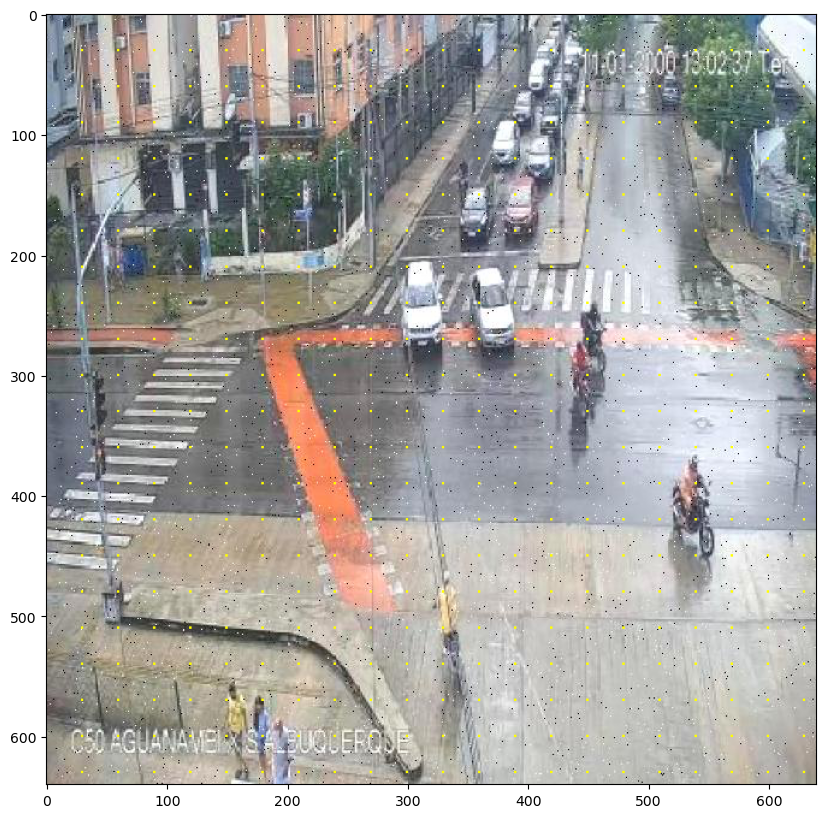

In [122]:
anchor_point_stride = 30
anchor_points = generate_anchor_points(image, anchor_point_stride)
anchor_points_image = add_anchor_points(image, anchor_points, 1)
plt.figure(figsize=(10, 10))
plt.imshow(anchor_points_image)

In [123]:
# The number of anchor points for an image
anchor_points.__len__(), ((image.shape[0] - anchor_point_stride) / anchor_point_stride) * ((image.shape[1] - anchor_point_stride) / anchor_point_stride)

(441, 413.4444444444444)

In [124]:
def generate_regions(anchor_points, region_ratios, region_scales):
    # Going for each anchor point
    regions = []
    for anchor in anchor_points:
        for ratio in region_ratios:
            for scale in region_scales:
                value = 1 * scale
                width = ratio[0] * value
                height = ratio[1] * value
                regions.append([anchor[0], anchor[1], width, height])
    return regions

def add_regions(image, regions, color=[0, 0, 0], thickness = 1):
    new_image = image.copy()
    index = 0
    for region in regions:
        x = region[0]
        y = region[1]
        width = region[2]
        height = region[3]
        topleft = [0 if x - width < 0 else x - width, 0 if y - height < 0 else y - height]
        topright = [image.shape[0] if x + width > image.shape[0] else  x + width, 0 if y - height < 0 else y - height]
        bottomleft = [0 if x - width < 0 else x - width, image.shape[1] if y + height > image.shape[1] else y + height]
        bottomright = [image.shape[0] if x + width > image.shape[0] else x + width, image.shape[1] if y + height > image.shape[1] else y + height]
        chosen_color = color[int(index / len(color))]
        index += 1
        new_image[topleft[0] : topright[0], topleft[1]:topleft[1] + thickness, :] = chosen_color
        new_image[topright[0]:topright[0] + thickness, topright[1]:bottomright[1], :] = chosen_color
        new_image[bottomleft[0] : bottomright[0], bottomleft[1] - thickness : bottomleft[1], :] = chosen_color
        new_image[bottomleft[0] - thickness : bottomleft[0], topleft[1]:bottomleft[1], :] = chosen_color
    return new_image

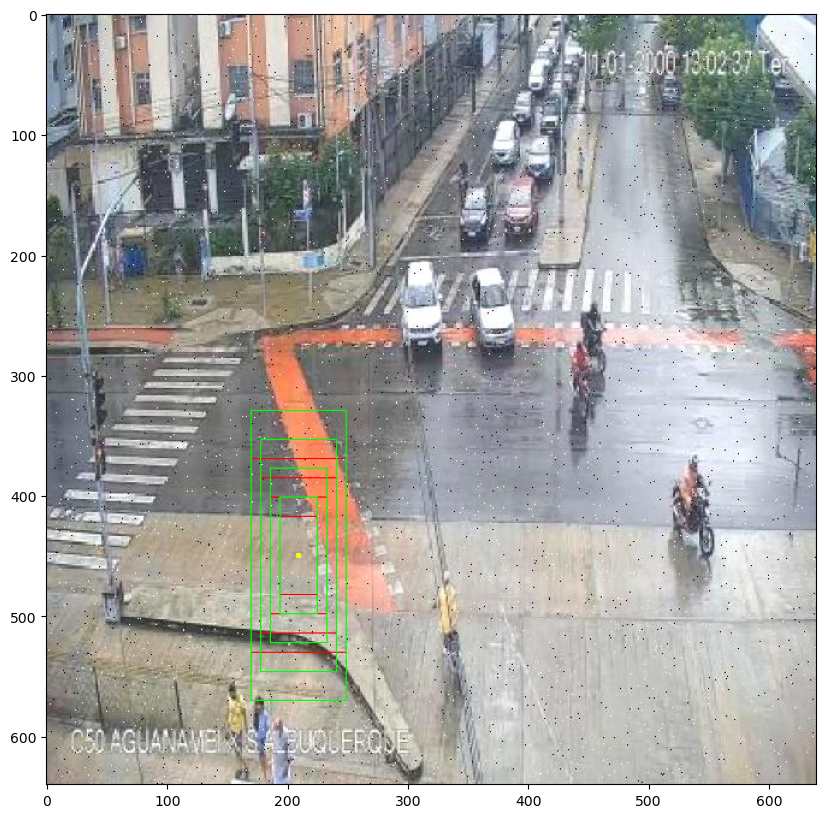

In [125]:
points = anchor_points
region_ratios = [[2, 1], [3, 1]]
region_scales = [16, 24, 32, 40]
regions = generate_regions(points, region_ratios, region_scales)

# Test Points
test_points = [points[300]]
test_regions = generate_regions(test_points, region_ratios, region_scales)
regioned_image = add_regions(image, test_regions, [[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0]], 1)
regioned_image = add_anchor_points(regioned_image, test_points, 2)
plt.figure(figsize=(10, 10))
plt.imshow(regioned_image)

In [126]:
print(f'Anchor Points: {len(anchor_points)}')
print(f'Regions: {len(regions)}')
print(f'Regions Calculation: {len(anchor_points) * len(region_ratios) * len(region_scales)}')

Anchor Points: 441
Regions: 3528
Regions Calculation: 3528


In [127]:
def overlapArea(rect1, rect2):

   # Finding the length and width of the overlap area
   x = max(0, min(rect1[2], rect2[2]) - max(rect1[0], rect2[0]))
   y = max(0, min(rect1[3], rect2[3]) - max(rect1[1], rect2[1]))
   area = x * y
   return area


In [128]:
# Generating Masks for each object in the image
def generate_masks(image, x, y, width, height):
    mask = np.zeros(image.shape)
    mask[x - width : x + width, y - height : y + height, :] = [1, 1, 1]
    return mask

# Checks whether the region goes out of the iamge at any side or not
def is_region_inside_image(image, region):
    x = region[0]
    y = region[1]
    width = region[2]
    height = region[3]

    if x - width < 0 or x + width > image.shape[0] or y - height < 0 or y + height > image.shape[1]:
        return False
    else:
        return True

def find_IOU(object_coords, target_region):
    a1 = (object_coords[3] * 2) * (object_coords[4] * 2)
    a2 = (target_region[2] * 2) * (target_region[3] * 2)
    rect1 = [object_coords[1] - object_coords[3], object_coords[2] - object_coords[4], object_coords[1] + object_coords[3], object_coords[2] + object_coords[4]]
    rect2 = [target_region[0] - target_region[2], target_region[1] - target_region[3], target_region[0] + target_region[2], target_region[1] + target_region[3]]
    # if object_coords[0] <= target_region[0] and object_coords[1] <= target_region[1]:
    #     point1 = (object_coords[0] + object_coords[2], object_coords[1] + object_coords[3])
    #     point2 = (target_region[0] - target_region[2], target_region[1] - target_region[3])
    #     intersection = [point1[0] - point2[0], point1[1] - point2[1]]
    # elif object_coords[0] <= target_region[0] and object_coords[1] >= target_region[1]:
    #     point1 = (object_coords[0] + object_coords[2], object_coords[1] - object_coords[3])
    #     point2 = (target_region[0] - target_region[2], target_region[1] + target_region[3])
    #     intersection = [point1[0] - point2[0], point2[1] - point1[1]]
    # elif object_coords[0] >= target_region[0] and object_coords[1] >= target_region[1]:
    #     point1 = (object_coords[0] - object_coords[2], object_coords[1] - object_coords[3])
    #     point2 = (target_region[0] + target_region[2], target_region[1] + target_region[3])
    #     intersection = [point2[0] - point1[0], point2[1] - point1[1]]
    # elif object_coords[0] >= target_region[0] and object_coords[1] <= target_region[1]:
    #     point1 = (object_coords[0] - object_coords[2], object_coords[1] + object_coords[3])
    #     point2 = (target_region[0] + target_region[2], target_region[1] - target_region[3])
    #     intersection = [point2[0] - point1[0], point1[1] - point2[1]]

    # if intersection[0] <= 0 or intersection[1] <= 0:
    #     intersection[0] = 0
    #     intersection[1] = 0
    intersection_area = overlapArea(rect1, rect2)
    # intersection_area = intersection[0] * intersection[1]
    total_area = a1 + a2 - intersection_area
    return intersection_area / total_area

def show_overlapping_area(region_mask, object_mask):
    main_mask = region_mask
    main_mask[main_mask == 1] = 0.5
    object_mask = object_mask
    object_mask[object_mask == 1] = 0.5
    combined_mask = main_mask + object_mask
    return combined_mask

In [129]:
region_targets = []
for region in tqdm(regions):
    if is_region_inside_image(image, region):
        for object_coords in object_coordinates:
            iou = find_IOU(object_coords, region)
            if iou > 0.5 or (iou < 0.3 and iou > 0):
                region_targets.append([1 if iou > 0.5 else 0, iou, object_coords[0], region[0], region[1], region[2], region[3]])

100%|██████████| 3528/3528 [00:00<00:00, 13390.86it/s]


In [146]:
def propose_regions(image, object_coordinates, anchor_point_stride = 20, region_ratios = [[1, 1], [2, 1], [3, 1]], region_scales = [16, 24, 32, 40], iou_limit = 0.5):

    anchor_points = generate_anchor_points(image, anchor_point_stride)
    regions = generate_regions(anchor_points, region_ratios, region_scales)
    region_targets = []
    for region in regions:
        if is_region_inside_image(image, region):
            for object_coords in object_coordinates:
                iou = find_IOU(object_coords, region)
                if iou > iou_limit or (iou < 0.3 and iou > 0):
                    region_targets.append([1 if iou > iou_limit else 0, iou, object_coords[0], region[0], region[1], region[2], region[3]])

    fine_regions = []
    non_fine_regions = []
    for i in range(0, len(region_targets)):
        if region_targets[i][0] == 1:
            fine_regions.append(region_targets[i])
        else:
            non_fine_regions.append(region_targets[i])

    if len(fine_regions) == 0:
        return []

    fine_regions = np.array(fine_regions, dtype=np.int32)
    # Taking non fine regions equal to that of fine regions
    random_region_indices = np.random.choice(len(non_fine_regions), len(fine_regions))
    non_fine_regions = np.array(non_fine_regions, dtype=np.int32)
    non_fine_regions = non_fine_regions[random_region_indices]
    region_targets = np.append(fine_regions, non_fine_regions, axis=0)
    region_targets = shuffle(region_targets)
    return region_targets

In [131]:
ious = [region[1] for region in region_targets]
max(ious)

0.7892976588628763

In [132]:
fine_regions = []
non_fine_regions = []
for i in range(0, len(region_targets)):
    if region_targets[i][0] == 1:
        fine_regions.append(region_targets[i])
    else:
        non_fine_regions.append(region_targets[i])
fine_regions = np.array(fine_regions, dtype=np.int32)
len(fine_regions), len(non_fine_regions)

(98, 3500)

In [133]:
# Taking non fine regions equal to that of fine regions
random_region_indices = np.random.choice(len(non_fine_regions), len(fine_regions))
non_fine_regions = np.array(non_fine_regions, dtype=np.int32)
non_fine_regions = non_fine_regions[random_region_indices]

In [134]:
np.append(non_fine_regions, fine_regions, axis=0).shape

(196, 7)

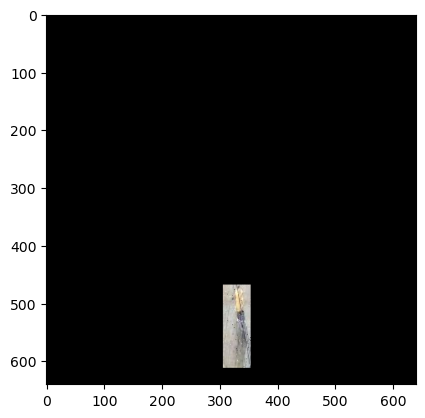

In [135]:
target = fine_regions
for i in range(94, len(target)):
    x = target[i][3]
    y = target[i][4]
    width = target[i][5]
    height=target[i][6]
    region_mask = generate_masks(image, x, y, width, height)
    new_image = image.copy()
    new_image[region_mask != 1] = 0
    plt.imshow(new_image)
    break

In [95]:
def resize_region(image, region, new_size = (64, 64)):
    x = region[3]
    y = region[4]
    width = region[5]
    height = region[6]
    cropped_image = image[x - width: x + width, y - height : y + height, :]
    cropped_image = np.reshape(cropped_image, (width * 2, height * 2, 3))
    cropped_image = cv2.resize(cropped_image, new_size)
    return cropped_image

(128, 64, 3)


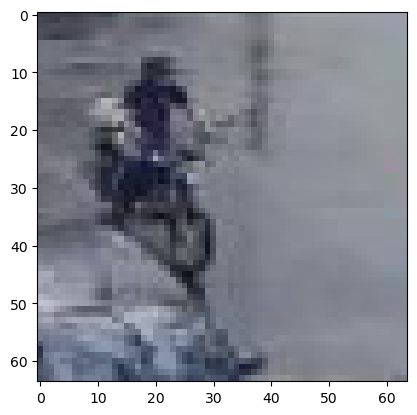

In [96]:
region = fine_regions[50]
x = region[3]
y = region[4]
width = region[5]
height = region[6]
cropped_image = image[x - width: x + width, y - height : y + height, :]
cropped_image = np.reshape(cropped_image, (width * 2, height * 2, 3))
print(cropped_image.shape)
cropped_image = cv2.resize(cropped_image, (64, 64))
plt.imshow(cropped_image)

In [343]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, folder, batch_size = 32, shuffle = True):
        self.folder = folder
        self.batch_size = batch_size
        self.images = os.listdir(f'{folder}/images')
        self.labels = os.listdir(f'{folder}/labels')
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return self.images.__len__() - 10
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        target_regions = []
        i = index
        while len(target_regions) == 0:
            X = []
            y = []
            region_ratios = [[1, 1], [2, 1]]
            region_scales = [16, 24, 32, 40]
            image, coords = load_image(self.folder, self.images, self.labels, i)
            target_regions = propose_regions(image, coords, anchor_point_stride=30, region_ratios=region_ratios, region_scales=region_scales)
            for region in target_regions:
                cropped_image = resize_region(image, region)
                X.append(cropped_image)
                y.append(region[0])
            i+=1
        X = np.array(X)
        y = np.array(y)
        return X, y

In [344]:
train_generator = DataGenerator(train_folder, 1)
valid_generator = DataGenerator(valid_folder, 1)

# Model Definition and Training

In [345]:
i = Input(shape=(64, 64, 3))
x = Conv2D(32, (3, 3), activation= 'relu')(i)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(32, (3, 3), activation= 'relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(32, (3, 3), activation= 'relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dense(units=128, activation='relu')(x)
x = Dense(units=1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 31, 31, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 12, 12, 32)        924

In [346]:
history = model.fit(train_generator, epochs= 10, steps_per_epoch=1000, validation_data=valid_generator, validation_steps=500)

Epoch 1/10
1000/1000 [==============================] - 185s 184ms/step - loss: 0.9916 - accuracy: 0.7084 - val_loss: 0.5096 - val_accuracy: 0.7633
Epoch 2/10
1000/1000 [==============================] - 179s 179ms/step - loss: 0.5389 - accuracy: 0.7388 - val_loss: 0.5644 - val_accuracy: 0.7378
Epoch 3/10
1000/1000 [==============================] - 179s 179ms/step - loss: 0.5114 - accuracy: 0.7623 - val_loss: 0.4969 - val_accuracy: 0.7685
Epoch 4/10
1000/1000 [==============================] - 188s 188ms/step - loss: 0.4825 - accuracy: 0.7800 - val_loss: 0.4977 - val_accuracy: 0.7808
Epoch 5/10
1000/1000 [==============================] - 186s 186ms/step - loss: 0.4765 - accuracy: 0.7855 - val_loss: 0.4679 - val_accuracy: 0.7834
Epoch 6/10
1000/1000 [==============================] - 184s 183ms/step - loss: 0.4712 - accuracy: 0.7861 - val_loss: 0.4690 - val_accuracy: 0.7915
Epoch 7/10
1000/1000 [==============================] - 185s 185ms/step - loss: 0.4523 - accuracy: 0.7969 - val_

In [370]:
# Saving the model
model.save('region_proposal_network.h5')

Text(0, 0.5, 'Loss')

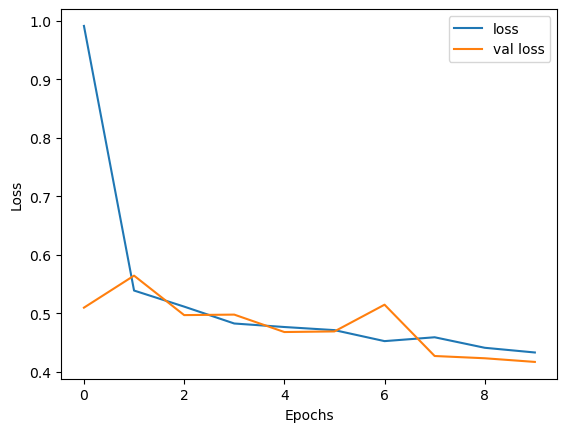

In [348]:
# Plotting the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

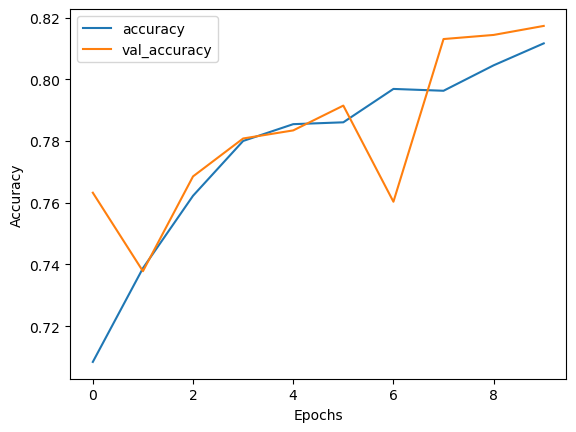

In [349]:
# Plotting the loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

0


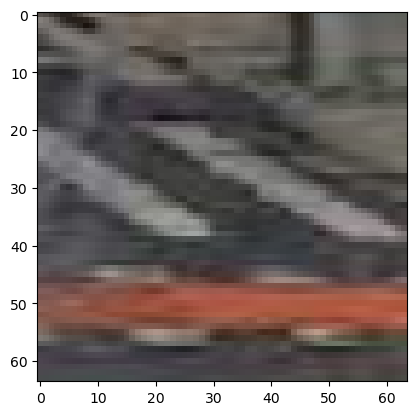

In [350]:
test_images = os.listdir(f'{test_folder}/images')
test_labels = os.listdir(f'{test_folder}/labels')
image_index = 5
test_image, test_object_coords = load_image(test_folder, test_images, test_labels, image_index)
test_target_regions = propose_regions(test_image, test_object_coords, anchor_point_stride, region_ratios, region_scales)
region_index = 2
test_cropped_image = resize_region(test_image, test_target_regions[region_index])
print(test_target_regions[region_index][0])
plt.imshow(test_cropped_image)

0
1/1 [==============================] - 0s 25ms/step
[  0   0   2 360 270  96  32]
0.050850518


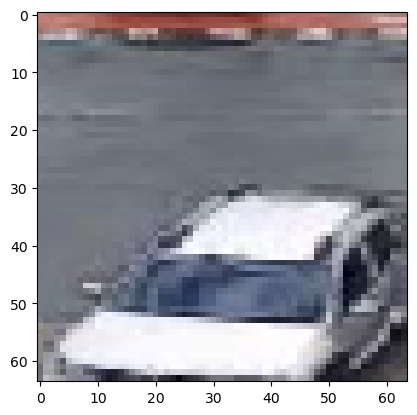

In [369]:
index = 34
print(test_target_regions[index][0])
prediction_image = resize_region(test_image, test_target_regions[index])
prediction_image = np.array([prediction_image])
res = model.predict(prediction_image)
res = np.squeeze(res)
print(test_target_regions[index])
print(res)
plt.imshow(prediction_image[0])